In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path

### Notehead Detection

In [3]:
imagefile = 'queries/p31_q7.jpg'

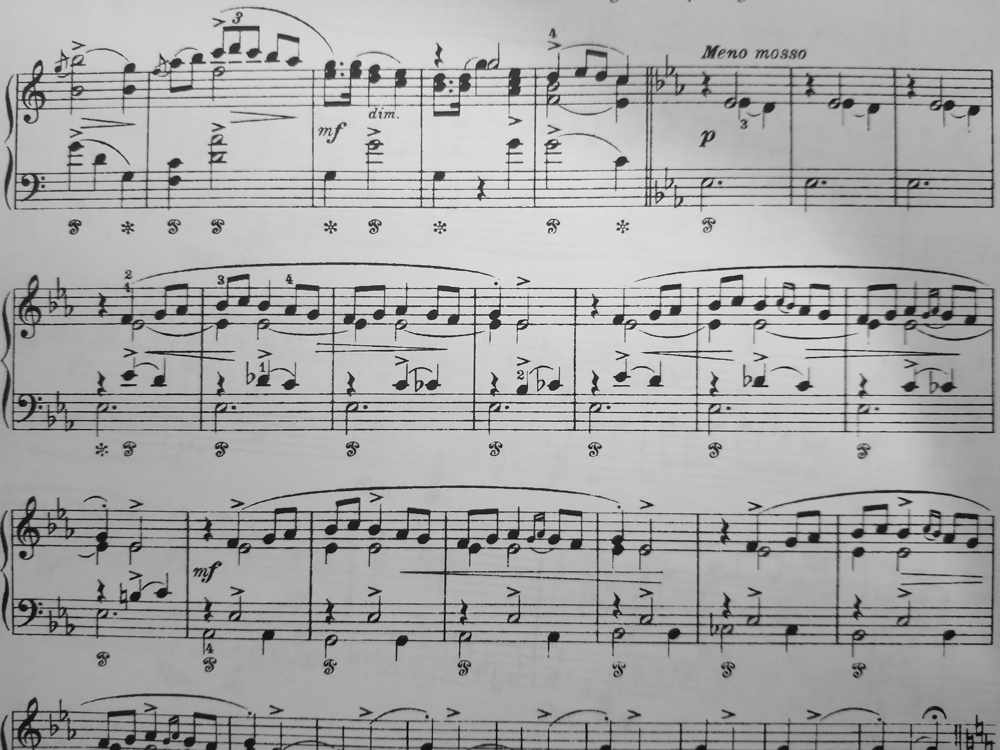

In [4]:
pim1 = Image.open(imagefile).convert('L') # pim indicates PIL image object, im indicates raw pixel values
pim1.thumbnail([1000, 1000]) # modifies in place
pim1

In [5]:
def removeBkgdLighting(pimg, filtsz=5, thumbnailW = 100, thumbnailH = 100):
    tinyimg = pimg.copy()
    tinyimg.thumbnail([thumbnailW, thumbnailH]) # resize to speed up
    shadows = tinyimg.filter(ImageFilter.MaxFilter(filtsz)).resize(pimg.size)
    result = ImageChops.invert(ImageChops.subtract(shadows, pimg))
    return result

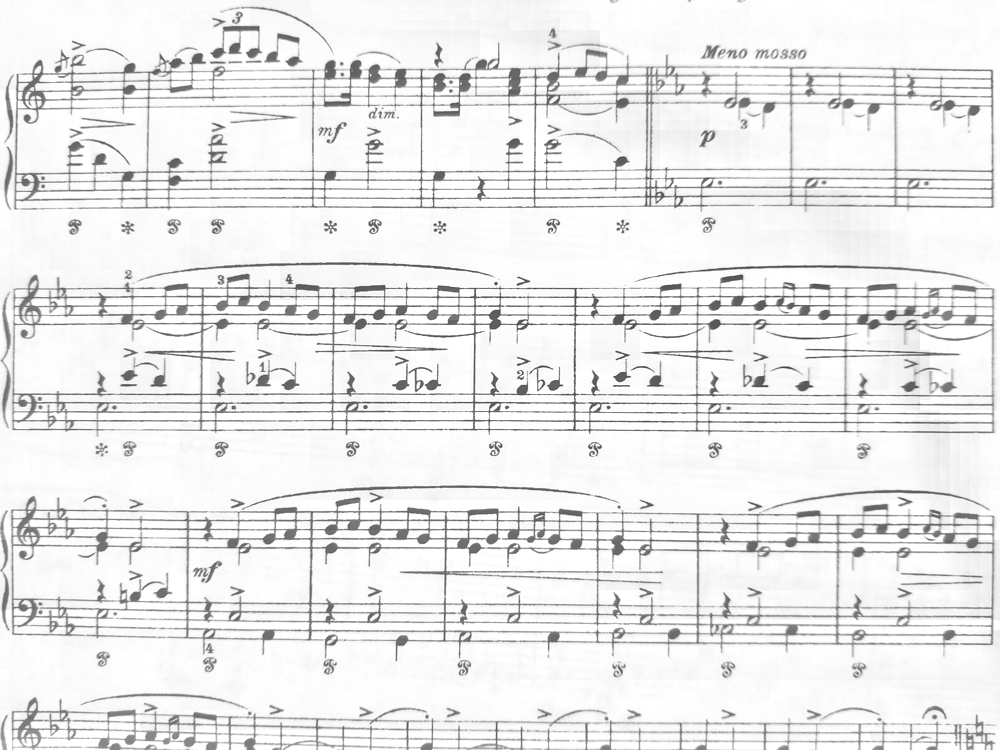

In [6]:
pim2 = removeBkgdLighting(pim1)
pim2

In [7]:
def morphFilterCircle(pimg, sz = 5, expand = False):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz,sz))
    result = cv2.dilate(np.array(pimg), kernel, iterations = 1)
    if expand:
        result = cv2.erode(result, kernel, iterations = 1)
    return result

In [8]:
def showGrayscaleImage(X, sz = (10,10), maxval = 1, inverted = True):
    # by default assumes X is a normalized image between 0 (white) and 1 (black)
    plt.figure(figsize = sz)
    if inverted:
        plt.imshow(maxval-X, cmap='gray')
    else:
        plt.imshow(X, cmap='gray')

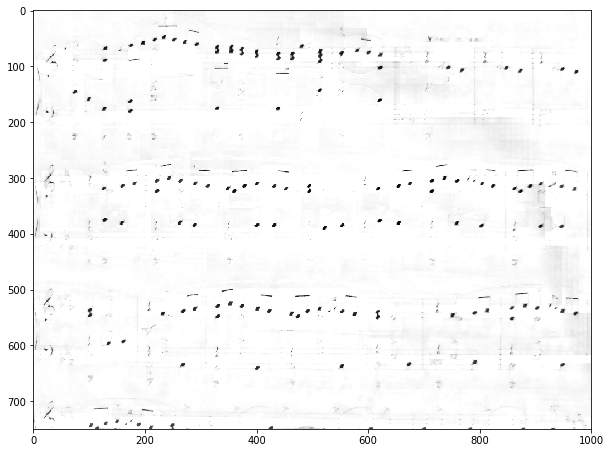

In [9]:
im3 = morphFilterCircle(pim2, 5, False) # from here on use raw pixel values, not PIL image object
showGrayscaleImage(im3, maxval = 255, inverted = False)

In [10]:
def detectNoteheadBlobs(img, minarea, maxarea):
    
    # define blob detector
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    # params.minThreshold = 100;
    # params.maxThreshold = 200;

    # Filter by Area
    # params.filterByArea = True
    params.minArea = minarea
    params.maxArea = maxarea

    # Filter by Circularity
    # params.filterByCircularity = True
    # params.minCircularity = 0.1

    # Filter by Convexity
    # params.filterByConvexity = True
    # params.minConvexity = 0.87

    # Filter by Inertia
    # params.filterByInertia = True
    # params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)
    
    keypoints = detector.detect(img)
    im_with_keypoints = cv2.drawKeypoints(np.array(img), keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return keypoints, im_with_keypoints

In [11]:
def showColorImage(X, sz = (10,10)):
    plt.figure(figsize = sz)
    plt.imshow(X)

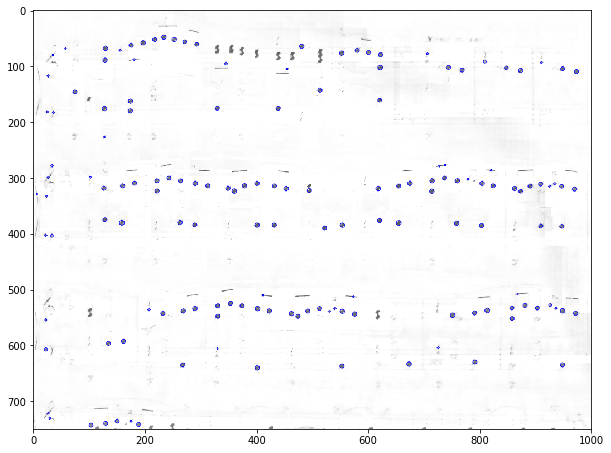

In [12]:
notedetect_maxarea = 100
notedetect_minarea = 10
keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
showColorImage(im_with_keypoints)

In [13]:
def getNormImage(img):
    X = 1 - np.array(img) / 255.0
    return X

In [14]:
def getNoteTemplate(arr, keypoints, sz = 21):
    template = np.zeros((sz,sz))
    L = (sz - 1)//2
    crops = []
    for k in keypoints:
        xloc = int(np.round(k.pt[0])) # col
        yloc = int(np.round(k.pt[1])) # row
        if xloc - L >= 0 and xloc + L + 1 <= arr.shape[1] and yloc - L >= 0 and yloc + L + 1 <= arr.shape[0]:
            crop = arr[yloc-L:yloc+L+1,xloc-L:xloc+L+1]
            crops.append(crop)
            template += crop
    template = template / len(crops)
    template = template - np.mean(template.ravel()) # will be used as a filter, so make zero mean
    return template, crops

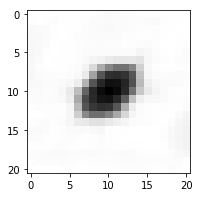

In [15]:
X3 = getNormImage(im3) # im indicates grayscale [0, 255], X indicates [0, 1] inverted grayscale
ntemplate, pcrops = getNoteTemplate(X3, keypoints)
showGrayscaleImage(ntemplate, (3,3), maxval = 1, inverted = True)

In [16]:
def getRandomCrops(arr, N=200, sz=21):
    crops = np.zeros((N,sz,sz))
    L = (sz-1)//2
    for i in range(N):
        yloc = np.random.randint(L, arr.shape[0]-L) # row
        xloc = np.random.randint(L, arr.shape[1]-L) # col
        crops[i,:,:] = arr[yloc-L:yloc+L+1,xloc-L:xloc+L+1]
    return crops

In [17]:
def comparePosNegDistributions(pcrops, ncrops, template):
    pos = []
    for crop in pcrops:
        pos.append(np.sum(crop * template))
    neg = []
    for crop in ncrops:
        neg.append(np.sum(crop*template))
    sns.kdeplot(np.array(pos))
    sns.kdeplot(np.array(neg))
    return pos, neg

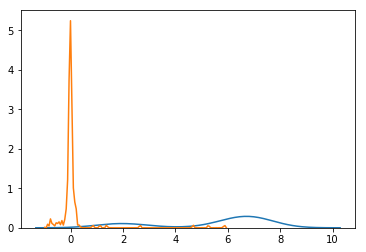

In [18]:
ncrops = getRandomCrops(X3)
pos, neg = comparePosNegDistributions(pcrops, ncrops, ntemplate)

In [19]:
def filterWithTemplate(arr, template):
    filtered = convolve2d(arr, np.flipud(np.fliplr(template)), mode='same', boundary='symm')
    return filtered

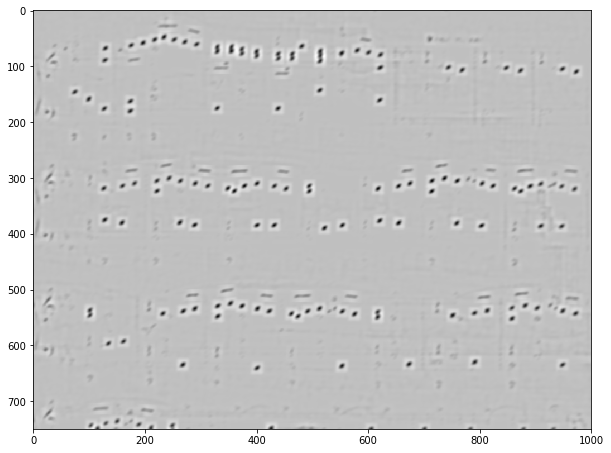

In [20]:
X4 = filterWithTemplate(X3, ntemplate)
showGrayscaleImage(X4)

In [21]:
def binarize_otsu(img):
    arr = np.array(img)
    thresh = filters.threshold_otsu(arr)
    binarized = arr > thresh
    return binarized

In [22]:
def isValidNotehead(region, arg):
    result = region.area <= arg[1] and region.area > arg[0]
    return result

In [23]:
def visualizeLabels(img, labels, fn, arg = None):
    
    img = np.array(img)
    image_label_overlay = label2rgb(labels, image=img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_label_overlay)

    for region in regionprops(labels):
        # take regions with large enough areas
        if fn(region, arg):
            # draw rectangle around valid regions
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

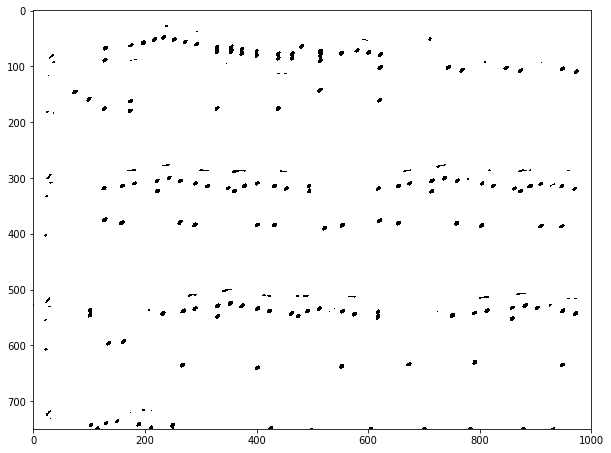

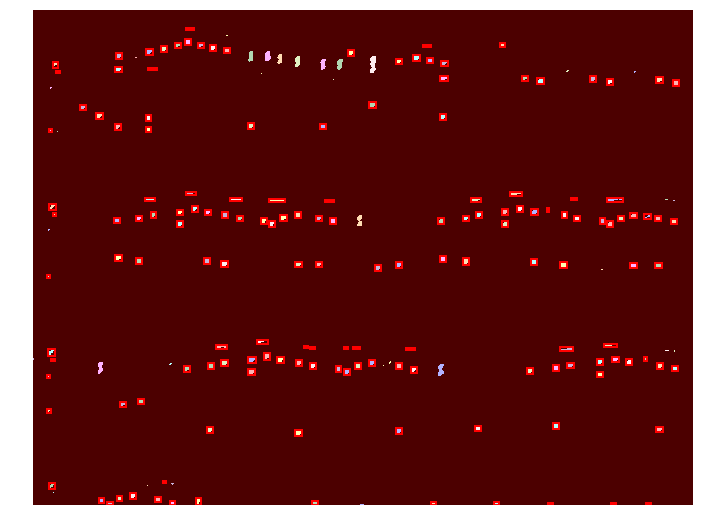

In [24]:
X4_bin = binarize_otsu(X4)
labels = measure.label(X4_bin)
showGrayscaleImage(X4_bin)
visualizeLabels(X4_bin, labels, isValidNotehead, arg = (notedetect_minarea, notedetect_maxarea))

In [25]:
def getContextRegion(arr, center, deltaR = 10, deltaC = 10):
    r = int(np.round(center[0]))
    c = int(np.round(center[1]))
    rupper = min(r + deltaR + 1, arr.shape[0])
    rlower = max(r - deltaR, 0)
    cupper = min(c + deltaC + 1, arr.shape[1])
    clower = max(c - deltaC, 0)
    crop = arr[rlower:rupper,clower:cupper] 
    return crop

In [26]:
def getContextRegion2(arr, rstart, rend, cstart, cend):
    rupper = min(rend, arr.shape[0])
    rlower = max(rstart, 0)
    cupper = min(cend, arr.shape[1])
    clower = max(cstart, 0)
    crop = arr[rlower:rupper,clower:cupper] 
    return crop

In [27]:
nhlocs = [region.centroid for region in regionprops(labels) if isValidNotehead(region, arg = (notedetect_minarea, notedetect_maxarea))]

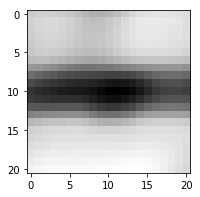

In [28]:
showGrayscaleImage(getContextRegion(X4, nhlocs[0]), (3,3))

In [29]:
nhlens = [(region.bbox[2] - region.bbox[0]) for region in regionprops(labels) if isValidNotehead(region, arg = (notedetect_minarea, notedetect_maxarea))]
nhwidths = [(region.bbox[3] - region.bbox[1]) for region in regionprops(labels) if isValidNotehead(region, arg = (notedetect_minarea, notedetect_maxarea))]

In [30]:
nhlen_est = int(np.ceil(np.mean(nhlens)))
nhwidth_est = int(np.ceil(np.mean(nhwidths)))
nhlen_est, nhwidth_est

(8, 10)

### Staff Line Detection

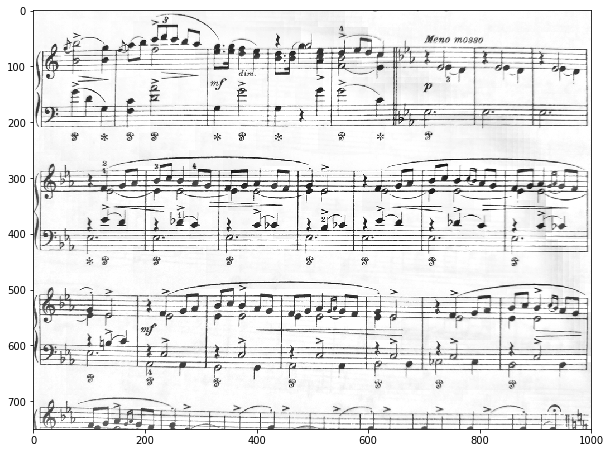

In [31]:
X2 = getNormImage(pim2)
showGrayscaleImage(X2)

In [32]:
def morphFilterLinesHoriz(arr, kernel_len = 51):
    kernel = np.ones((1,kernel_len),np.uint8)
    hlines = cv2.erode(arr, kernel, iterations = 1)
    hlines = cv2.dilate(hlines, kernel, iterations = 1)
    return hlines

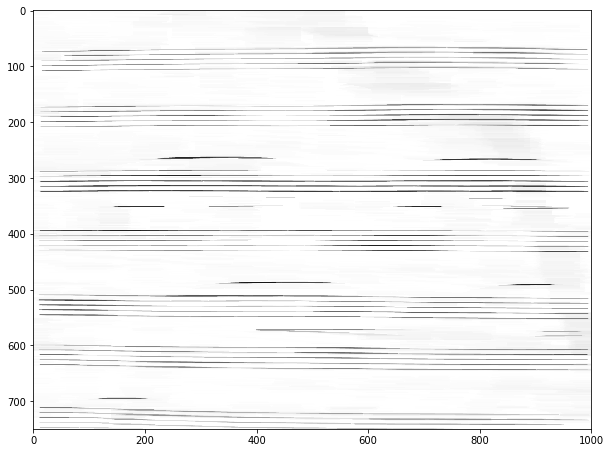

In [33]:
kernel_len = 51
hlines = morphFilterLinesHoriz(X2, kernel_len)
showGrayscaleImage(hlines)

In [34]:
def createCombFilters(estNoteheadHeight, tol = .25):
    # create comb filters of different lengths
    # e.g. if length is 44, then spikes at indices 0, 11, 22, 33, 44
    # e.g. if length is 43, then spikes at 0 [1.0], 10 [.25], 11 [.75], 21 [.5], 22 [.5], 32 [.75], 33 [.25], 43 [1.0]
    stavelen_ll = int((1 - tol) * 4 * estNoteheadHeight)
    stavelen_ul = int(np.ceil((1 + tol) * 4 * estNoteheadHeight))
    stavelens = np.arange(stavelen_ll, stavelen_ul)
    combfilts = np.zeros((len(stavelens), stavelens[-1], 1))
    for i, stavelen in enumerate(stavelens):
        for j in range(5):
            idx = j * (stavelen-1) / 4.0
            idx_below = int(idx)
            idx_above = idx_below + 1
            remainder = idx - idx_below
            combfilts[i, idx_below, 0] = 1 - remainder
            if idx_above < combfilts.shape[1]:
                combfilts[i, idx_above, 0] = remainder
    return combfilts, stavelens

In [35]:
def computeStaveFeatureMap(arr, combfilts, rowfiltlen):
    featmap = []
    rowfilt = np.ones((1, rowfiltlen))
    for i in range(combfilts.shape[0]):
        m = convolve2d(arr, np.fliplr(np.flipud(combfilts[i])), mode = 'valid')
        m = convolve2d(m, rowfilt, mode = 'same')
        featmap.append(m)
    featmap = np.array(featmap)
    return featmap

In [36]:
combfilts, stavelens = createCombFilters(nhlen_est)
featmap = computeStaveFeatureMap(hlines, combfilts, kernel_len)

In [37]:
def getEstStaffLineLocs(featmap, nhlocs, arr, stavelens, deltaRowMax = 70, globoffset = 0):
    preds = []
    for nhloc in nhlocs:
        r = int(np.round(nhloc[0]))
        c = int(np.round(nhloc[1]))
        rupper = min(r + deltaRowMax + 1 - np.max(stavelens), arr.shape[0])
        rlower = max(r - deltaRowMax, 0)
        reg = np.squeeze(featmap[:, rlower:rupper, c])
        if len(stavelens) == 1:
            roffset = reg.argmax()
            mapidx = 0
        else:
            mapidx, roffset = np.unravel_index(reg.argmax(), reg.shape)
        rstart = rlower + globoffset + roffset
        rend = rstart + stavelens[mapidx] - 1
        preds.append((rstart, rend, c, r, mapidx))
    return preds

In [38]:
def visualizeEstStaffLines(preds, arr):
    showGrayscaleImage(arr, (15,15))
    rows1 = np.array([pred[0] for pred in preds]) # top staff line
    rows2 = np.array([pred[1] for pred in preds]) # bottom staff line
    cols = np.array([pred[2] for pred in preds]) # nh col
    rows3 = np.array([pred[3] for pred in preds]) # nh row
    plt.scatter(cols, rows1, c = 'r', s = 3)
    plt.scatter(cols, rows2, c = 'b', s = 3)
    plt.scatter(cols, rows3, c = 'y', s = 3)

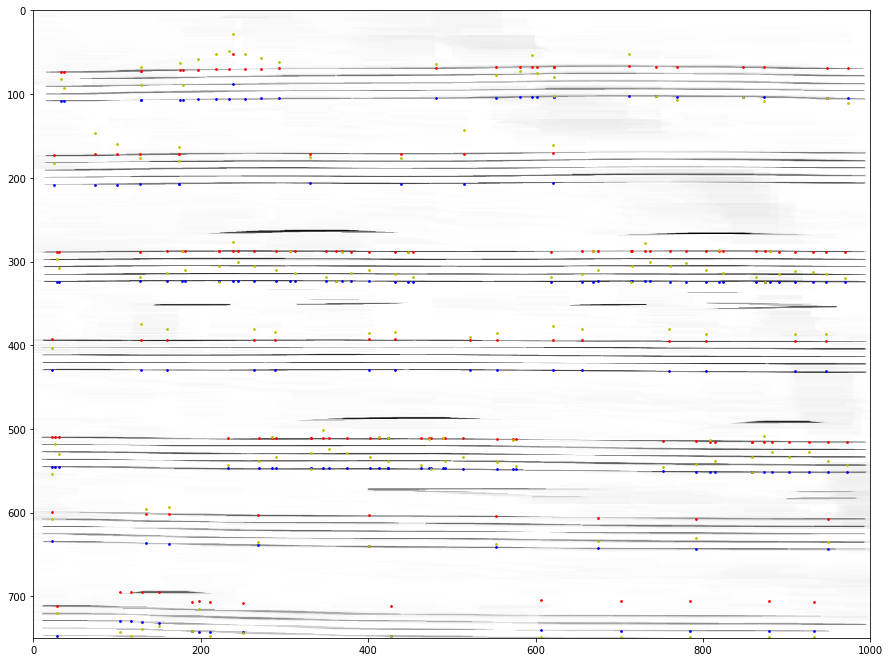

In [39]:
estStaffLineLocs = getEstStaffLineLocs(featmap, nhlocs, hlines, stavelens)
visualizeEstStaffLines(estStaffLineLocs, hlines)

In [40]:
def getStaveTemplate(arr, preds, filtlen, rbuff = 0):
    crops = np.zeros((len(preds), 2*rbuff + filtlen, 1))
    for i, tup in enumerate(preds):
        (rstart, rend, c, r, filtidx) = tup
        reg = getContextRegion2(arr, rstart - rbuff, rstart + filtlen + rbuff, c, c + 1)
        crops[i, 0:reg.shape[0], :] = reg
    template = np.mean(crops, axis=0)
    template = template - np.mean(template.ravel())
    return template, crops

37

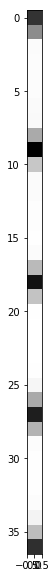

In [41]:
sfiltlen = int(np.median([stavelens[tup[4]] for tup in estStaffLineLocs]))
stemplate, scrops = getStaveTemplate(hlines, estStaffLineLocs, sfiltlen)
showGrayscaleImage(stemplate)
sfiltlen

In [43]:
# re-estimate staff line locations using staff template
# featmap_adapt = computeStaveFeatureMap(hlines, np.expand_dims(stemplate, axis=0), kernel_len)
# estStaffLineLocs_adapt = getEstStaffLineLocs(featmap_adapt, nhlocs, hlines, [sfiltlen])
# visualizeEstStaffLines(estStaffLineLocs_adapt, hlines)

### Barline Detection

In [44]:
def morphFilterLinesVert(arr, kernel_length = 51, kernel_width = 5):
    vkernel = np.ones((kernel_length, 1), np.uint8)
    hkernel = np.ones((1, kernel_width), np.uint8)
    lines = cv2.erode(arr, vkernel, iterations = 1)
    lines = cv2.dilate(lines, vkernel, iterations = 1)
    lines = cv2.dilate(lines, hkernel, iterations = 1)
    return lines

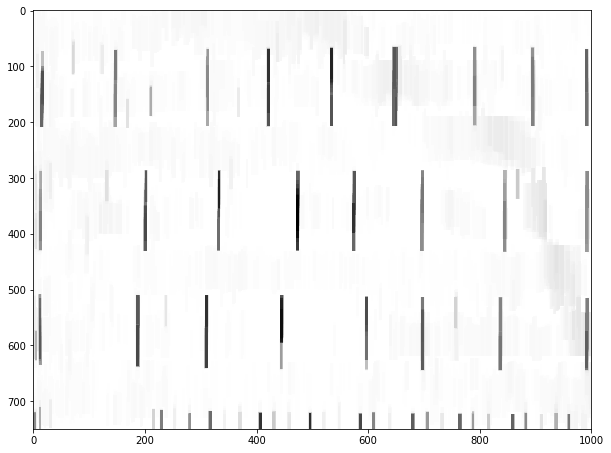

In [45]:
vlines = morphFilterLinesVert(X2, kernel_len)
showGrayscaleImage(vlines)

In [46]:
def estimateBarlineThreshold(labels):
    heights = [region.bbox[2] - region.bbox[0] for region in regionprops(labels)]
    thresh = filters.threshold_otsu(np.expand_dims(heights, axis= 0))
    return thresh

In [47]:
def isValidBarline(region, arg):
    height = region.bbox[2] - region.bbox[0]
    result = height > arg
    return result

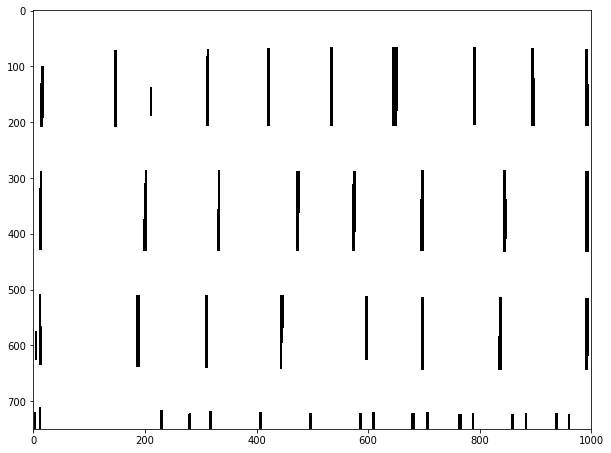

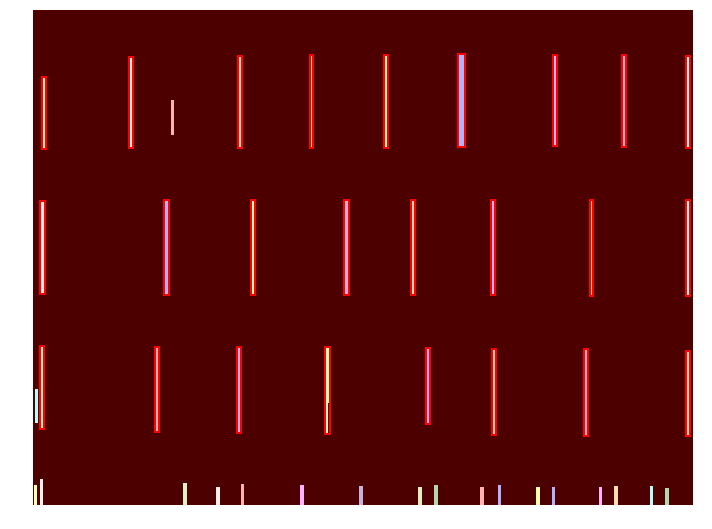

In [48]:
vlines_bin = binarize_otsu(vlines)
vlabels = measure.label(vlines_bin)
showGrayscaleImage(vlines_bin)
bar_thresh = estimateBarlineThreshold(vlabels)
visualizeLabels(vlines_bin, vlabels, isValidBarline, bar_thresh)

In [49]:
def clusterBarlines(barlines):
    midpts = [.5*(b[1] + b[0]) for b in barlines]
    radius = np.median([b[1] - b[0] for b in barlines])
    clusters = -1*np.ones(len(barlines), dtype=np.int8)
    clusterIndex = 0
    for i in range(len(barlines)):
        if clusters[i] == -1: # has not been assigned a cluster yet
            clusterCenter = midpts[i]
            for j in range(i,len(barlines)):
                if np.abs(midpts[j] - clusterCenter) < radius:
                    clusters[j] = clusterIndex
            clusterIndex += 1
    
    # also return the bounds of each cluster
    cluster_bnds = []
    for i in range(clusterIndex):
        selected = np.array([b for j, b in enumerate(barlines) if clusters[j] == i])
        bnds = np.median(selected, axis=0)
        cluster_bnds.append((bnds[0], bnds[1]))
    
    return clusters, cluster_bnds

In [50]:
barlines = [(reg.bbox[0], reg.bbox[2]) for reg in regionprops(vlabels) if reg.bbox[2] - reg.bbox[0] > bar_thresh]
barline_clusters, barline_clusterbnds = clusterBarlines(barlines)
barline_clusterbnds

[(68.0, 208.0), (287.5, 431.0), (511.5, 641.5)]

### Cluster and Label Noteheads

In [51]:
def estimateNoteLabels(preds, staveH):
    midpts  = [((.5 * (tup[0] + tup[1])), tup[2]) for tup in preds] # stave midpt locations (row, col)
    tree = KDTree(np.array(midpts)) # use kdtree to find nearest neighbors
    nhvals = [] # estimated note labels
    midpts2 = [] # updated estimate of nearest stave midpoints (stave assignment may change)
    for i, (rstart, rend, c, r, filtidx) in enumerate(preds):
        _, idx = tree.query((r,c), k=1)
        midpt_row = midpts[idx][0] # row location of nearest stave midpoint
        nhval = estimateNoteStaveLoc(r, midpt_row, staveH)
        nhvals.append(nhval)
        midpts2.append(midpt_row)
    return nhvals, midpts2

In [52]:
def estimateNoteStaveLoc(r, r0, staveH):
    # if a stave has height L, there are 8 stave locations in (L-1) pixel rows
    noteStaveLoc = -1.0 * (r - r0) * 8 / (staveH - 1)
    discretized = int(np.round(noteStaveLoc))
    return discretized

In [53]:
def visualizeNoteLabels(arr, vals, locs):
    showGrayscaleImage(arr)
    rows = np.array([loc[0] for loc in locs])
    cols = np.array([loc[1] for loc in locs])
    plt.scatter(cols, rows, color='blue')
    for i in range(len(rows)):
        plt.text(cols[i], rows[i] - 15, str(vals[i]), fontsize = 12, color='red')

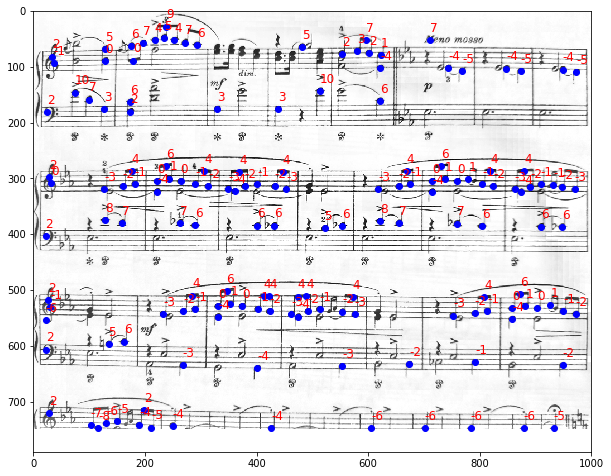

In [54]:
nhvals, nhmidpts = estimateNoteLabels(estStaffLineLocs, sfiltlen)
visualizeNoteLabels(X2, nhvals, nhlocs)

In [55]:
def clusterNoteheads(midpts, barlines):
    clusters = np.zeros(len(midpts), dtype=np.int8) # cluster index of each note
    for i, midpt in enumerate(midpts):
        clusteridx = -1 # -1 means notehead is not within a valid barline region
        for j, (lb, ub) in enumerate(barlines):
            if midpt >= lb and midpt <= ub:
                lb_dist = np.abs(midpt - lb)
                ub_dist = np.abs(midpt - ub)
                if lb_dist < ub_dist: # rh staff
                    clusteridx = 2*j
                else:
                    clusteridx = 2*j + 1 # lh staff
                break
        clusters[i] = clusteridx     
    return clusters

In [56]:
def visualizeClusters(arr, preds, clusters):
    showGrayscaleImage(arr)
    rows = np.array([tup[3] for tup in preds])
    cols = np.array([tup[2] for tup in preds])
    plt.scatter(cols, rows, c=clusters)
    for i in range(len(clusters)):
        plt.text(cols[i], rows[i] - 15, str(clusters[i]), fontsize = 12, color='red')

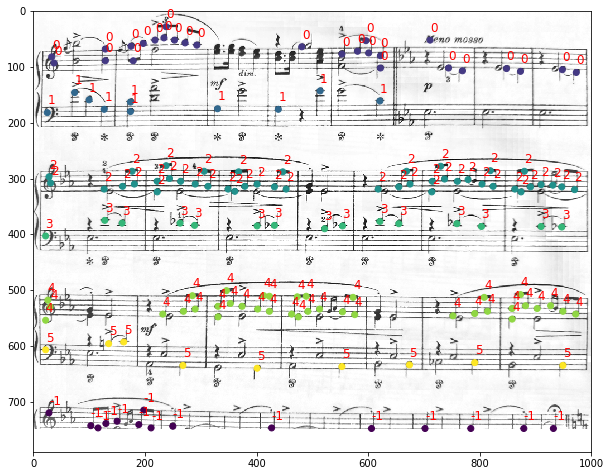

In [57]:
nhclusters = clusterNoteheads(nhmidpts, barline_clusterbnds)
clusterPairs = np.arange(2 * len(barline_clusterbnds)).reshape((-1,2))
visualizeClusters(X2, estStaffLineLocs, nhclusters)

In [57]:
# def clusterStaves(nhclusters, stavelocs, barlineInfo):
    
#     # estimate each stave's vertical position based on all notes in the stave
#     numStaves = nhclusters.max() + 1
#     avgStaveLocs = [] 
#     for i in range(numStaves):
#         avgStaveLoc = np.median([sloc for j, sloc in enumerate(stavelocs) if nhclusters[j] == i])
#         avgStaveLocs.append(avgStaveLoc)
        
#     # cluster staves
#     staveClusters = []
#     for (lb, ub) in barlineInfo:
#         matches = []
#         for j, sloc in enumerate(avgStaveLocs):
#             if sloc >= lb and sloc <= ub:
#                 matches.append(j)
#         assert(len(matches) == 2)
#         stavePairs.append(matches)
    
#     return stavePairs, staveLocs

### Generate Bootleg Score

In [58]:
def generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes = 1, filler = 1):
    notes = [tup for tup in nhdata if tup[3] == clusterR or tup[3] == clusterL]
    notes = sorted(notes, key = lambda tup: (tup[1], tup[0])) # sort by column, then row
    collapsed = collapseSimultaneousEvents(notes, nhwidth_est) # list of (rows, cols, vals, clusters)
    bscore, eventIndices, staffLinesBoth, _, _ = constructBootlegScore(collapsed, clusterR, clusterL, repeatNotes, filler)
    return bscore, collapsed, eventIndices, staffLinesBoth

In [59]:
def collapseSimultaneousEvents(notes, minColDiff):
    assigned = np.zeros(len(notes), dtype=bool)
    events = [] # list of simultaneous note events
    for i, (row, col, val, cluster) in enumerate(notes):
        if assigned[i]: # has already been assigned
            continue
        rows = [row] # new event
        cols = [col]
        vals = [val]
        clusters = [cluster]
        assigned[i] = True
        for j in range(i+1, len(notes)):
            nrow, ncol, nval, ncluster = notes[j]
            if ncol - col < minColDiff: # assign to same event if close
                rows.append(nrow)
                cols.append(ncol)
                vals.append(nval)
                clusters.append(ncluster)
                assigned[j] = True
            else:
                break
        events.append((rows, cols, vals, clusters))
    
    assert(np.all(assigned))
    return events

In [60]:
def constructBootlegScore(noteEvents, clusterIndexRH, clusterIndexLH, repeatNotes = 1, filler = 1):
    # note that this has to match generateBootlegScore() in the previous notebook!
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    eventIndices = [] # index of corresponding simultaneous note event
    for i, (rows, cols, vals, clusters) in enumerate(noteEvents):
        
        # insert empty filler columns between note events
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim,1)))
                lh.append(np.zeros((lh_dim,1)))
                eventIndices.append(i-1) # assign filler to previous event

        # insert note events columns
        rhvec, lhvec = getNoteheadPlacement(vals, clusters, rh_dim, lh_dim, clusterIndexRH, clusterIndexLH)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            eventIndices.append(i)
    rh = np.squeeze(np.array(rh)).reshape((-1, rh_dim)).T # reshape handles case when len(rh) == 1
    lh = np.squeeze(np.array(lh)).reshape((-1, lh_dim)).T
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, eventIndices, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [61]:
def getNoteheadPlacement(vals, clusters, rdim, ldim, clusterRH, clusterLH):
    rhvec = np.zeros((rdim, 1))
    lhvec = np.zeros((ldim, 1))
    assert(clusterLH == clusterRH + 1)
    for (val, cluster) in zip(vals, clusters):
        if cluster == clusterRH:
            idx = val + 11
            if idx >= 0 and idx < rdim:
                rhvec[idx, 0] = 1
        elif cluster == clusterLH:
            idx = val + 17
            if idx >= 0 and idx < ldim:
                lhvec[idx, 0] = 1
        else:
            print("Invalid cluster: {} (LH {}, RH {})".format(cluster, clusterLH, clusterRH))
            sys.exit(1)
    return rhvec, lhvec

In [62]:
def visualizeBootlegScore(bs, lines):
    plt.figure(figsize = (10,10))
    plt.imshow(1 - bs, cmap = 'gray', origin = 'lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'grey')
    for l in lines:
        plt.axhline(l, c = 'r')

In [63]:
# list of (row, col, value, cluster) tuples
nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]

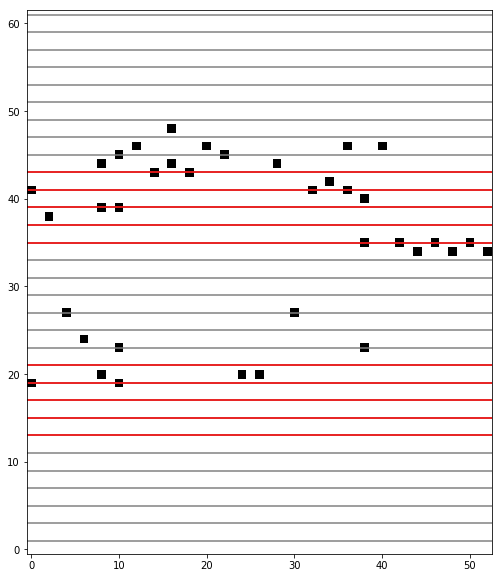

In [64]:
bscore, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR = 0, clusterL = 1, minColDiff = nhwidth_est, repeatNotes = 1, filler = 1)
visualizeBootlegScore(bscore, staffLinesBoth)

In [65]:
def generateQueryBootlegScore(nhdata, pairings, repeatNotes = 1, filler = 1, minColDiff = 10):
    allScores = []
    allEvents = []
    globIndices = []
    eventCount = 0
    for i, (clusterR, clusterL) in enumerate(pairings):
        score, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes, filler)
        allScores.append(score)
        allEvents.extend(events)
        globIndices.extend([idx + eventCount for idx in eventIndices])
        if i < len(pairings) - 1:
            allScores.append(np.zeros((score.shape[0], filler))) # append filler columns between bootleg scores
            globIndices.extend([globIndices[-1]] * filler) # map filler columns to last event index
        eventCount += len(events)
    panorama = np.hstack(allScores)
    return panorama, allEvents, globIndices, staffLinesBoth

In [66]:
def visualizeLongBootlegScore(bs, lines, chunksz = 150):
    chunks = bs.shape[1] // chunksz + 1
    for i in range(chunks):
        startcol = i * chunksz
        endcol = min((i + 1)*chunksz, bs.shape[1])
        visualizeBootlegScore(bs[:,startcol:endcol], lines)

In [67]:
bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, repeatNotes = 2, filler = 2, minColDiff = nhwidth_est)

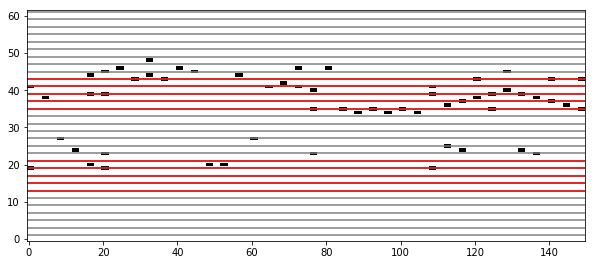

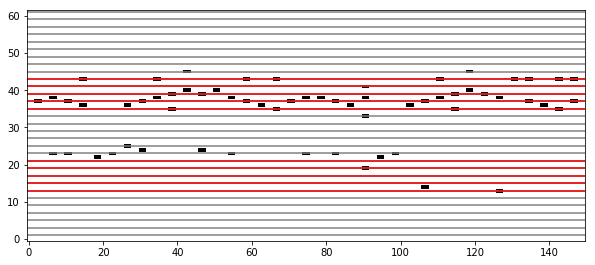

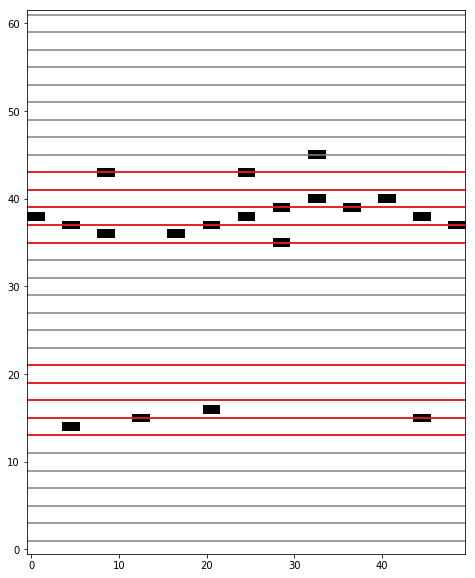

In [68]:
visualizeLongBootlegScore(bscore_query, staffLinesBoth)

### Align bootleg scores

In [69]:
def loadMidiBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    miditimes = d['times']
    stafflines = d['stafflines']
    return bscore, miditimes, stafflines

In [70]:
# def subseqDTW(C, steps, weights):
    
#     # compute cumulative cost matrix
#     numsteps = steps.shape[0]
#     D = np.zeros(C.shape) # cumulative cost
#     B = np.zeros(C.shape, dtype = np.uint8) # backtrace
#     D[0,:] = C[0,:]
#     queryFrames, refFrames = C.shape
#     for qcur in range(1,queryFrames):
#         for rcur in range(refFrames):
#             bestcost = np.inf
#             bestidx = -1
#             for i in range(numsteps):
#                 qprev = qcur - steps[i,0]
#                 rprev = rcur - steps[i,1]
#                 if qprev >= 0 and rprev >= 0:
#                     cost = D[qprev, rprev] + weights[i] * C[qcur,rcur]
#                     if cost < bestcost:
#                         bestcost = cost
#                         bestidx = i
#             D[qcur,rcur] = bestcost
#             B[qcur,rcur] = bestidx
    
#     # backtrace
#     wp = []
#     q = C.shape[0]-1
#     r = np.argmin(D[-1,:])
#     wp.append((q,r))
#     while(q > 0):
#         stepidx = B[q,r]
#         qstep, rstep = steps[stepidx,:]
#         q = q - qstep
#         r = r - rstep
#         wp.append((q,r))
#     wp = np.array(wp)
    
#     return D, wp

In [71]:
def costMetric(X,Y):
    cost = -1 * np.dot(X,Y) #np.matmul(X.T, Y)
    return cost

In [72]:
def alignBootlegScores(query, ref, steps = [1,1,1,2,2,1], weights = [1,1,2]):
    steps = np.array(steps).reshape((-1,2))
    D, wp = lb.sequence.dtw(query, ref, step_sizes_sigma = steps, weights_mul = weights, subseq = True, metric = costMetric)
    return D, wp

In [73]:
def plotAlignment(D, wp, seginfo = None):
    plt.figure(figsize = (10,10))
    plt.imshow(D, origin = 'lower', cmap = 'jet')
    plt.plot(wp[:,1], wp[:,0], color='y')
    plt.xlabel('Ref')
    plt.ylabel('Query')
    if seginfo is not None:
        matchSegTime, refSegTime, refSegCol = seginfo
        plt.title('Hyp ({:.1f} s, {:.1f} s), Ref ({:.1f} s, {:.1f} s)'.format(matchSegTime[0], matchSegTime[1], refSegTime[0], refSegTime[1]))
        plt.axvline(refSegCol[0], color = 'm')
        plt.axvline(refSegCol[1], color = 'm')
    else:
        plt.title('Subsequence DTW Alignment')

In [74]:
def getPredictedTimestamps(wp, times):
    start_frm_midi = wp[-1,1]
    end_frm_midi = wp[0,1]
    start_time_midi = times[start_frm_midi][0] # in sec
    end_time_midi = times[end_frm_midi][0]
    start_tick_midi = times[start_frm_midi][1] # in ticks
    end_tick_midi = times[end_frm_midi][1]
    return (start_time_midi, end_time_midi), (start_tick_midi, end_tick_midi)

In [75]:
def getGroundTruthTimestamps(imgfile, col2times):
    
    # get ground truth start, end times
    query = os.path.splitext(os.path.basename(imgfile))[0] # e.g. '/path/to/dir/p1_q10.jpg'
    query_gt_file = 'query_info/query.gt'
    (tstart, tend) = (0, 0)
    with open(query_gt_file, 'r') as f:
        for line in f:
            parts = line.rstrip().split(',')
            if parts[0] == query:
                tstart = float(parts[1])
                tend = float(parts[2])
                break
    
    # get start, end columns in bootleg score
    bscore_cols = np.arange(len(col2times))
    times = [tup[0] for tup in col2times]
    col_start, col_end = np.interp([tstart, tend], times, bscore_cols)
    
    return (tstart, tend), (col_start, col_end)

In [76]:
pieceStr = os.path.basename(imagefile).split('_')[0]
midi_bscore_pkl = 'experiments/exp1/db/{}.pkl'.format(pieceStr)
bscore_midi, miditimes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)

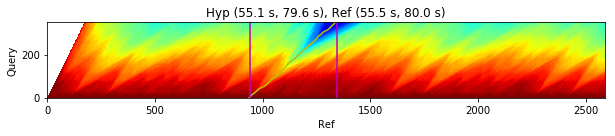

In [77]:
D, wp = alignBootlegScores(bscore_query, bscore_midi)
matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)
refSegmentTime, refSegmentCol = getGroundTruthTimestamps(imagefile, miditimes)
plotAlignment(D, wp, (matchSegmentTime, refSegmentTime, refSegmentCol))

In [78]:
def visualizeAlignedBScores(s1, s2, wp, lines):
    idxs1 = wp[::-1, 0]
    warped1 = s1[:,idxs1]
    idxs2 = wp[::-1, 1]
    warped2 = s2[:,idxs2]
    stacked = np.vstack((warped2, warped1))
    allLines = []
    allLines.extend(lines)
    allLines.extend(np.array(lines) + s1.shape[0])
    visualizeLongBootlegScore(stacked, allLines)

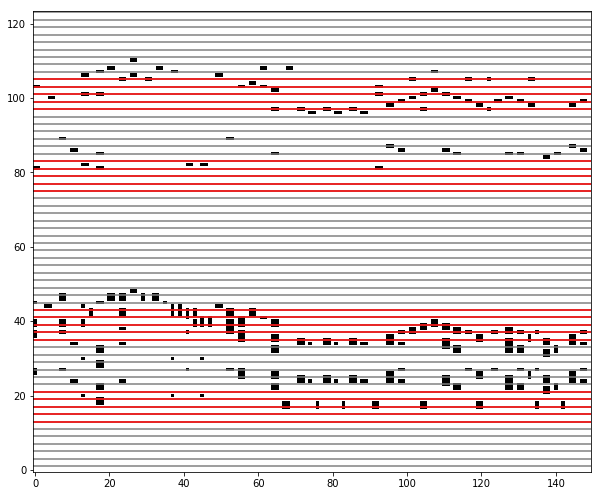

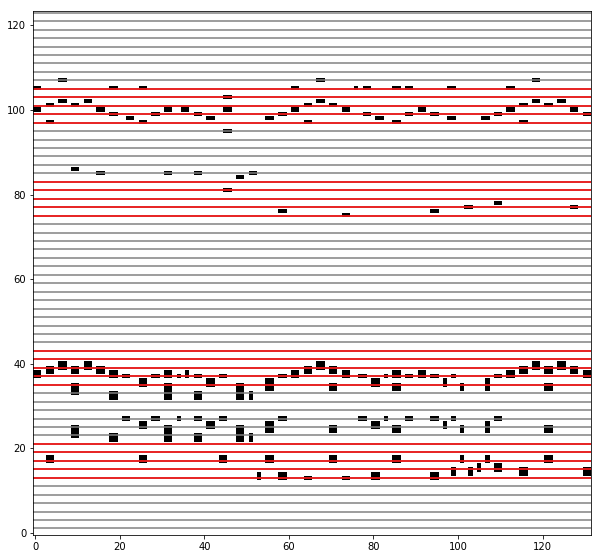

In [79]:
visualizeAlignedBScores(bscore_query, bscore_midi, wp, stafflines)

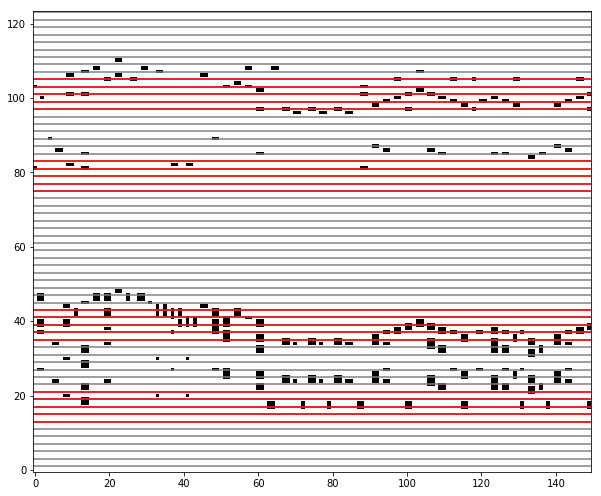

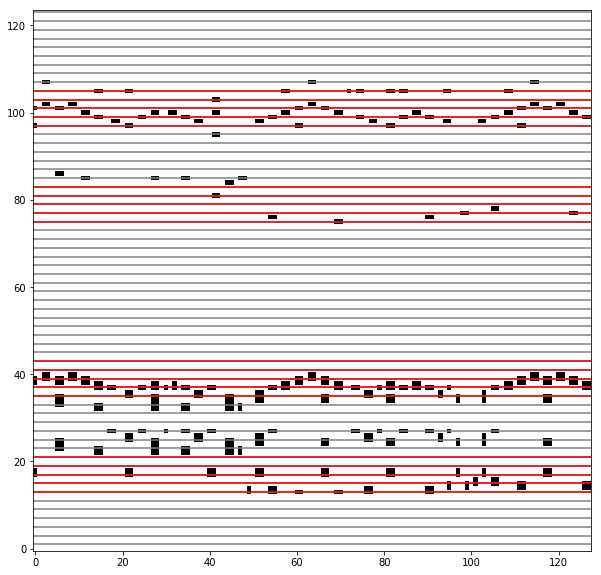

In [80]:
# visualize alignment between query and ground truth reference segment
bscore_midi_refseg = bscore_midi[:,int(refSegmentCol[0]):int(refSegmentCol[1])]
D2, wp2 = alignBootlegScores(bscore_query, bscore_midi_refseg)
visualizeAlignedBScores(bscore_query, bscore_midi_refseg, wp2, stafflines)

### Run system on all files

In [81]:
def processQuery(imagefile, midi_bscore_pkl, outfile = None, debugfile = None):

    ### system parameters ###
    resizeW = 1000 # resize image
    resizeH = 1000
    thumbnailW = resizeW // 10  # bkgd lighting
    thumbnailH = resizeH // 10
    thumbnailFilterSize = 5
    morphFilterCircleSize = 5 # notehead detection
    notedetect_minarea = 10
    notedetect_maxarea = 100 
    noteTemplateSize = 21
    morphFilterHorizLineSize = 51 # staff line detection
    combFilterSizeTol = .25
    maxDeltaRow = 70
    staveTemplateBuff = 0
    morphFilterVertLineLength = 51 # bar line detection
    morphFilterVertLineWidth = 5
    bootlegRepeatNotes = 2 # generating bootleg score
    bootlegFiller = 2
    dtw_steps = [1,1,1,2,2,1] # dtw
    dtw_weights = [1,1,2]
    ##########################
    
    print("Processing {}".format(imagefile))
    profileStart = time.time()
    
    # remove background lighting
    pim1 = Image.open(imagefile).convert('L')
    pim1.thumbnail([resizeW, resizeH])
    pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)

    # notehead detection
    im3 = morphFilterCircle(pim2, morphFilterCircleSize, False)
    keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
    X3 = getNormImage(im3)
    ntemplate, pcrops = getNoteTemplate(X3, keypoints, noteTemplateSize)
    X4 = filterWithTemplate(X3, ntemplate)
    X4_bin = binarize_otsu(X4)
    labels = measure.label(X4_bin)
    nhlocs = [region.centroid for region in regionprops(labels) if isValidNotehead(region, arg = (notedetect_minarea, notedetect_maxarea))]
    nhlens = [(region.bbox[2] - region.bbox[0]) for region in regionprops(labels) if isValidNotehead(region, arg = (notedetect_minarea, notedetect_maxarea))]
    nhwidths = [(region.bbox[3] - region.bbox[1]) for region in regionprops(labels) if isValidNotehead(region, arg = (notedetect_minarea, notedetect_maxarea))]
    nhlen_est = int(np.ceil(np.mean(nhlens)))
    nhwidth_est = int(np.ceil(np.mean(nhwidths)))

    # staff line detection
    X2 = getNormImage(pim2)
    hlines = morphFilterLinesHoriz(X2, morphFilterHorizLineSize)
    combfilts, stavelens = createCombFilters(nhlen_est, combFilterSizeTol)
    featmap = computeStaveFeatureMap(hlines, combfilts, morphFilterHorizLineSize)
    estStaffLineLocs = getEstStaffLineLocs(featmap, nhlocs, hlines, stavelens, maxDeltaRow)
    sfiltlen = int(np.median([stavelens[tup[4]] for tup in estStaffLineLocs]))

    # bar line detection
    vlines = morphFilterLinesVert(X2, morphFilterVertLineLength, morphFilterVertLineWidth)
    vlines_bin = binarize_otsu(vlines)
    vlabels = measure.label(vlines_bin)
    bar_thresh = estimateBarlineThreshold(vlabels)
    barlines = [(reg.bbox[0], reg.bbox[2]) for reg in regionprops(vlabels) if reg.bbox[2] - reg.bbox[0] > bar_thresh]
    barline_clusters, barline_clusterbnds = clusterBarlines(barlines)

    # cluster and label noteheads
    nhvals, nhmidpts = estimateNoteLabels(estStaffLineLocs, sfiltlen)
    nhclusters = clusterNoteheads(nhmidpts, barline_clusterbnds)
    clusterPairs = np.arange(2 * len(barline_clusterbnds)).reshape((-1,2))
    
    # generate & align bootleg scores
    nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]
    bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, bootlegRepeatNotes, bootlegFiller, minColDiff = nhwidth_est)
    bscore_midi, miditimes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)
    D, wp = alignBootlegScores(bscore_query, bscore_midi, dtw_steps, dtw_weights)
    matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)
    
    # profiling
    profileEnd = time.time()
    profileDur = profileEnd - profileStart
    
    # print hypothesis to file
    if outfile:
        with open(outfile, 'w') as f:
            outStr = "{},{:.2f},{:.2f}\n".format(os.path.splitext(os.path.basename(imagefile))[0], matchSegmentTime[0], matchSegmentTime[1])
            f.write(outStr)
    
    # save debugging info
    if debugfile:
        d = {'im_with_keypoints': im_with_keypoints, 'ntemplate': ntemplate, 
             'nhlen_est': nhlen_est, 'nhwidth_est': nhwidth_est,
             'estStaffLineLocs': estStaffLineLocs, 
             'barlines': barlines, 'barline_clusters': barline_clusters, 'barline_clusterbnds': barline_clusterbnds,
             'nhvals': nhvals, 'nhmidpts': nhmidpts, 'nhclusters': nhclusters, 'clusterPairs': clusterPairs,
             'nhdata': nhdata, 'bscore_query': bscore_query, 'events': events, 'eventIndices': eventIndices,
             'staffLinesBoth': staffLinesBoth, 'wp': wp, 'matchSegmentTime': matchSegmentTime,
             'matchSegmentTick': matchSegmentTick, 'profileDur': profileDur}
        with open(debugfile, 'wb') as f:
            pickle.dump(d, f)
    
    return (matchSegmentTime, matchSegmentTick, profileDur)

In [82]:
# process single query
query_file = 'queries/p11_q4.jpg'
pieceStr = os.path.basename(query_file).split('_')[0]
midi_bscore_file = 'experiments/exp1/db/{}.pkl'.format(pieceStr)
matchTimes, _, _ = processQuery(query_file, midi_bscore_file)
matchTimes
#cProfile.run("processQuery(query_file, midi_bscore_file)") # for profiling

In [83]:
def processAllQueries(filelist, mididir, outdir):
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    with open(filelist, 'r') as f:
        for line in f:
            queryfile = line.rstrip()
            basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
            hyp_outfile = "{}/{}.hyp".format(outdir, basename)
            debug_outfile = "{}/{}.pkl".format(outdir, basename)
            piece = basename.split('_')[0]
            midiBootlegFile = "{}/{}.pkl".format(mididir, piece)
            processQuery(queryfile, midiBootlegFile, hyp_outfile, debug_outfile)

In [85]:
# process all queries
query_list = 'cfg_files/query.train.list' # list of query images
midi_bs_dir = 'experiments/exp1/db' # directory containing midi bootleg scores
outdir = 'experiments/exp1/hyp' # where to save hypothesis output files
processAllQueries(query_list, midi_bs_dir, outdir)

Processing queries/p31_q7.jpg
